In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import sqlite3
from IPython.display import JSON
import matplotlib.ticker as mtick

In [68]:
conn = sqlite3.connect("../github-lambda-java/database.sqlite")
pd.read_sql_query("SELECT * FROM LambdaInfo LIMIT 5", conn).head()

id                              clazz  \
0   1  evaluation.InvocationFieldContext   
1   2  evaluation.InvocationFieldContext   
2   3  evaluation.InvocationFieldContext   
3   4       evaluation.InvocationContext   
4   5       evaluation.InvocationContext   

                                    name          type  outside_references  \
0  InvocationFieldContext(name=validate)      validate                   0   
1  InvocationFieldContext(name=validate)      validate                   1   
2  InvocationFieldContext(name=validate)      validate                   0   
3   InvocationContext(text=assertThrows)  assertThrows                   6   
4   InvocationContext(text=assertThrows)  assertThrows                   4   

                                                file side_effecting  \
0  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
1  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
2  /home/csicar/data/Uni/BachelorArbeit/github-la...             NO   
3  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
4  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   

    body_kind  file_line                                        source_text  \
0  EXPRESSION       2428  Validator.of(sarah).validate(User::getName, Ob...   
1  EXPRESSION       2348  Validator.of(sarah).validate(User::getName, Ob...   
2  EXPRESSION       2278  Validator.of(sarah).validate(User::getName, Ob...   
3   STATEMENT       1808  assertThrows(IllegalStateException.class, ()->...   
4   STATEMENT       1537  assertThrows(IllegalStateException.class, ()->...   

                                   inner_source_text  \
0                       (email)->email.contains("@")   
1                           (sex)->sex == Sex.FEMALE   
2                                    (age)->age > 21   
3  ()->{\n    Validator.of(john).validate(User::g...   
4  ()->{\n    Validator.of(tom).validate(User::ge...   

                                         project_url  \
0  https://api.github.com/repos/iluwatar/java-des...   
1  https://api.github.com/repos/iluwatar/java-des...   
2  https://api.github.com/repos/iluwatar/java-des...   
3  https://api.github.com/repos/iluwatar/java-des...   
4  https://api.github.com/repos/iluwatar/java-des...   

                    project_name  
0  iluwatar/java-design-patterns  
1  iluwatar/java-design-patterns  
2  iluwatar/java-design-patterns  
3  iluwatar/java-design-patterns  
4  iluwatar/java-design-patterns

In [4]:
df = pd.read_sql_query("""SELECT clazz, type, name, refs, count_name FROM 
    (
        SELECT count(*) as count_name, avg(outside_references) as refs,  * 
        FROM LambdaInfo 
        Where not (file like "%/test/%" or file like "%/tests/%") 
        GROUP BY name 
        ORDER BY count_name DESC
    )""", conn)
df.head(7)

clazz             type  \
0  evaluation.InvocationFieldContext              map   
1  evaluation.InvocationFieldContext          forEach   
2  evaluation.InvocationFieldContext           filter   
3           evaluation.ReturnContext           RETURN   
4  evaluation.InvocationFieldContext  computeIfAbsent   
5  evaluation.InvocationFieldContext        ifPresent   
6  evaluation.InvocationFieldContext              put   

                                           name      refs  count_name  
0              InvocationFieldContext(name=map)  2.535116        6507  
1          InvocationFieldContext(name=forEach)  5.329598        6068  
2           InvocationFieldContext(name=filter)  1.196473        5217  
3                    ReturnContext(type=RETURN)  6.861244        3344  
4  InvocationFieldContext(name=computeIfAbsent)  3.613960        1404  
5        InvocationFieldContext(name=ifPresent)  3.322373        1399  
6              InvocationFieldContext(name=put)  2.078032        1179

In [5]:
totalNumberOfLambdas = pd.read_sql_query("SELECT count(*) as c FROM LambdaInfo ", conn)['c'][0]
totalNumberOfLambdas

151480

total number of Lambdas found

In [6]:
normalLambdaCount = pd.read_sql_query("""
    SELECT count(*) as c FROM LambdaInfo Where not (file like "%/test/%" or file like "%/tests/%") """, conn)['c'][0]
normalLambdaCount

73496

number of lambdas that are not in tests

In [7]:
javaFileCount = pd.read_sql_query("""
    SELECT count(*) as c, file FROM LambdaInfo GROUP BY file ORDER BY c DESC""", conn)
javaFileCount['file'].count()

37355

In [8]:
javaFileCount = pd.read_sql_query("""
    SELECT count(*) as c, file FROM LambdaInfo WHERE NOT (file LIKE "%/test/%" or file LIKE "%/tests/%") GROUP BY file ORDER BY c DESC""", conn)
javaFileCount['file'].count()

22991

#  How are the uses distributed?

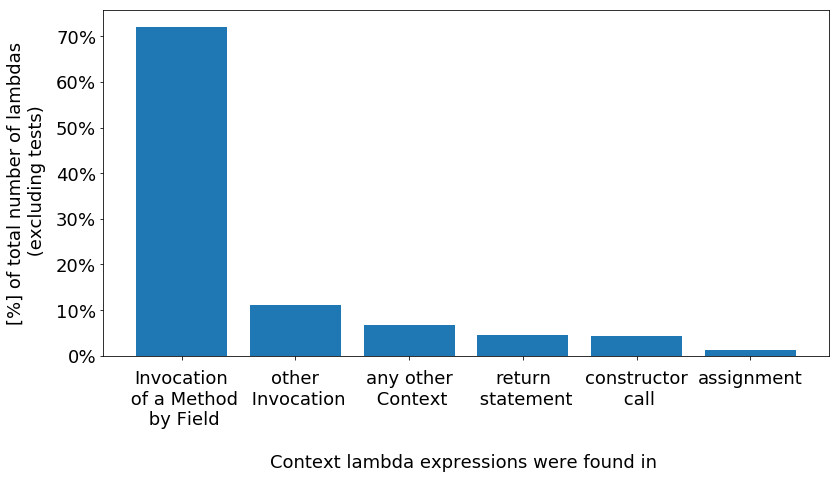

In [9]:
lambdasByCoarseCategory = pd.read_sql_query("""
    SELECT *, count(*) as lambda_count
    FROM LambdaInfo
    WHERE NOT (file LIKE "%/test/%" OR file LIKE "%/tests/%") 
    GROUP BY clazz
    ORDER BY lambda_count DESC""", conn)

nice_clazz_name_map = {
    "evaluation.InvocationFieldContext": "Invocation\n of a Method\n by Field",
    "evaluation.InvocationContext": "other\n Invocation",
    "evaluation.OtherContext": "any other\n Context",
    "evaluation.ReturnContext": "return\n statement",
    "evaluation.NewClassContext": "constructor\n call",
    "evaluation.AssignContext": "assignment"
}

nice_clazz_names = map(lambda clazz: nice_clazz_name_map[clazz], lambdasByCoarseCategory['clazz'])


plt.rcParams.update({'font.size': 18})



plt.figure(figsize=(12, 7))
plt.bar(np.arange(6), 100*lambdasByCoarseCategory['lambda_count'] / normalLambdaCount)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("[%] of total number of lambdas\n (excluding tests)", labelpad=10)
plt.xlabel("Context lambda expressions were found in ", labelpad=25)
plt.xticks(np.arange(6), nice_clazz_names)
for tick in plt.gca().xaxis.get_major_ticks()[0:]:
    tick.set_pad(10)

plt.tight_layout()
plt.savefig("coarse_category.png", pad_inches=-10)
plt.show()


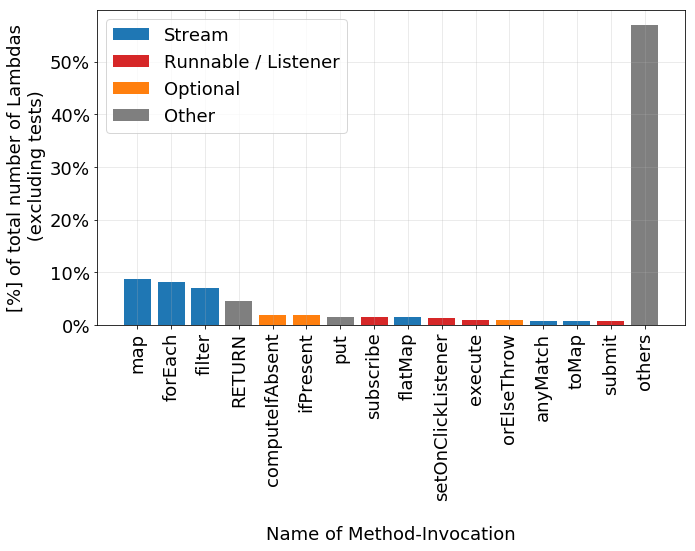

In [10]:
numOfElements = 15

def firsts(col):
    return col[0:numOfElements]

indices = np.arange(numOfElements+1)
types = pd.concat([   firsts(df["type"]), pd.Series(["others"])   ])
counts = pd.concat([  firsts(df["count_name"]), pd.Series([ df["count_name"][numOfElements:].sum()  ]) ])
colorCategory = {
    "Stream": ("tab:blue", ["map", "forEach", "filter", "flatMap", "anyMatch", "toMap"]),
    "Runnable / Listener": ("tab:red", ["subscribe", "setOnClickListener", "execute", "submit"]),
    "Optional": ("tab:orange", ["computeIfAbsent", "ifPresent", "orElseThrow"]),
    "Other": ("tab:grey", ["others", "RETURN", "put"]),
}
colors = [ ([ colorCategory[name][0] for name in colorCategory if t in colorCategory[name][1] ] + ["tab:grey"])[0] for t in types ]
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 18})

plt.grid(alpha=0.3)

for category in colorCategory:
    methodNames = colorCategory[category][1]
    countIfInCategory = [count if tt in methodNames else 10 for (count, tt) in zip(counts, types)]
    ax = plt.bar(
        indices,
        100 * np.array(countIfInCategory) / normalLambdaCount, color=colorCategory[category][0])


plt.legend([categoryName for categoryName in colorCategory])

plt.ylabel("[%] of total number of Lambdas\n (excluding tests)")
plt.xlabel("Name of Method-Invocation", labelpad=25)
plt.xticks(indices, types, rotation='vertical')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()
plt.savefig("fine_category.png")
plt.show()

# How relevant are the use-cases that Cok identified in AWS?

## Functions as arguments

In [11]:
lambdaInArgument = pd.read_sql_query("""
    SELECT * FROM LambdaInfo
    WHERE NOT (file LIKE "%/test/%" OR file LIKE "%/tests/%") 
    AND clazz like "evaluation.Invocation%" """, conn)
lambdaInArgument['clazz'].count() / normalLambdaCount

0.8315282464351802

## Functions as variables

In [12]:
df[(df['clazz'] == "evaluation.AssignContext") | (df['type'] == "VARIABLE")]['count_name'].sum() / normalLambdaCount

0.05837052356590835

number of lambda-expressions that were found in a assign-context

## Lambdas in Streams

In [13]:
lambdaStreamUses = pd.read_sql_query("""
    SELECT * FROM LambdaInfo
    
    WHERE NOT (file LIKE "%/test/%" OR file LIKE "%/tests/%") 
    AND source_text LIKE "%.stream()%" OR source_text LIKE "%Collections.%" """, conn)
lambdaStreamUses['clazz'].count() / normalLambdaCount

0.18373789049744205

## How many uses of FP in methods?

In [14]:
methodCount = pd.read_sql_query("""
    SELECT count(*) as c FROM MethodInfo""", conn)['c'][0]
methodCount

5334726

In [15]:
pd.read_sql_query("""SELECT * FROM MethodInfo WHERE NOT name LIKE "%test%" ORDER BY number_lines DESC LIMIT 5 """, conn)

id  number_fp_features  number_lines         name  \
0  5154022                   0         30379          foo   
1  2562979                   0          5231  jjMoveNfa_0   
2  3081717                   0          4231         main   
3  3081738                   0          4231         main   
4  1781328                   0          3187         next   

                                         source_text  
0  \nprotected void foo() {\n    int j = 4;\n    ...  
1  \nprivate int jjMoveNfa_0(int startState, int ...  
2  \npublic static void main(String[] args) throw...  
3  \npublic static void main(String[] args) throw...  
4  \npublic String next() throws java.io.IOExcept...

In [16]:
fpMethodUses = pd.read_sql_query("""
    SELECT 
        avg(number_fp_features) as avg_fp_features,
        count(*) as number_of_methods,
        avg(number_lines) as avg_number_lines 
    FROM MethodInfo
    GROUP BY number_fp_features > 0
    """, conn)
fpMethodUses.head()

avg_fp_features  number_of_methods  avg_number_lines
0         0.000000            5219700          8.624175
1         1.820075             115026         16.195173

In [17]:
100* fpMethodUses['number_of_methods'][1] / methodCount

2.1561744689417974

% of methods have FP features

In [18]:
def groupFP(rawdata):
    max_lines = 30#rawdata["number_lines"].max()
    data = rawdata.groupby(pd.cut(rawdata["number_lines"], np.arange(0, max_lines, 2))).sum()
    
    return data
   

fpLength = pd.read_sql_query("""
    SELECT
        count(*) as count_methods,
        number_lines,
        avg(number_fp_features) as avg_fp_features
    FROM MethodInfo
    WHERE number_fp_features > 0
    GROUP BY number_lines
    ORDER BY number_lines
    """, conn)


fpLengthGrouped = groupFP(fpLength)

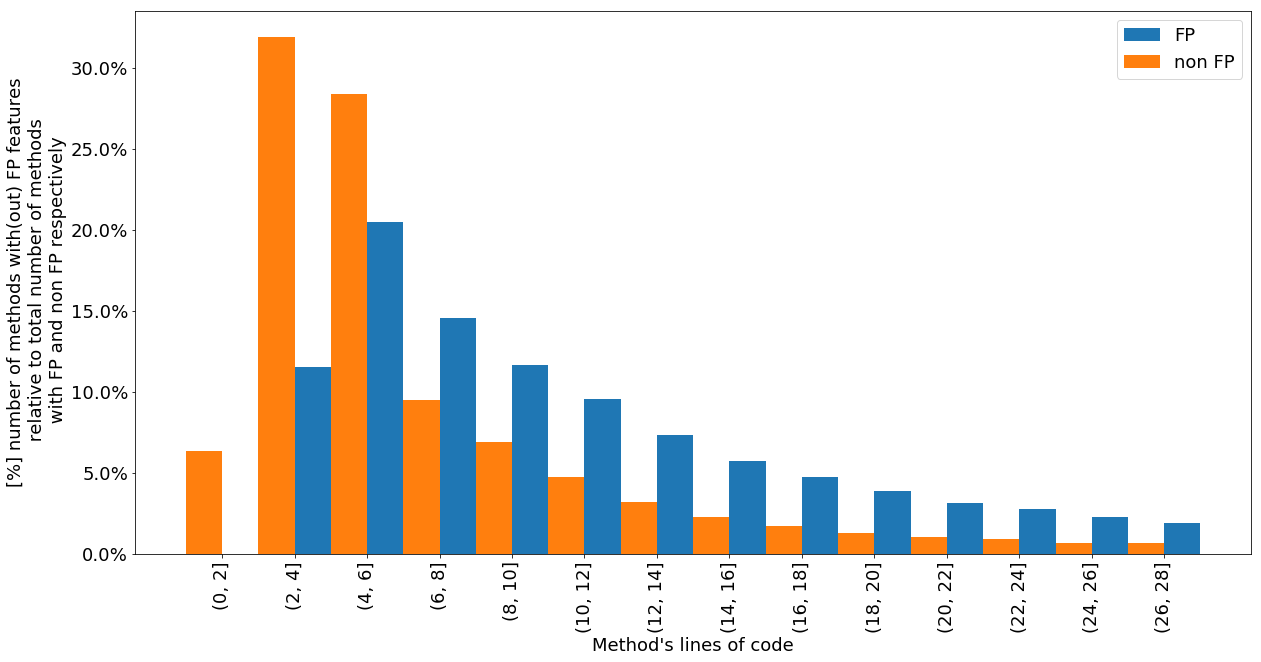

In [19]:
nonFpLength = pd.read_sql_query("""
    SELECT
        count(*) as count_methods,
        number_lines,
        avg(number_fp_features) as avg_fp_features
    FROM MethodInfo
    WHERE number_fp_features == 0
    GROUP BY number_lines
    ORDER BY number_lines
    """, conn)

def relativeData(data):
    return 100*data / data.sum()

nonFpLengthGrouped = groupFP(nonFpLength)

indices = np.arange(fpLengthGrouped["count_methods"].count())
plt.figure(figsize=(20, 10))
#plt.gca().set_yscale("log")
plt.bar(indices+0.25, relativeData(fpLengthGrouped["count_methods"]), 0.5)
plt.bar(indices-0.25, relativeData(nonFpLengthGrouped["count_methods"]), 0.5)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.xticks(indices, fpLengthGrouped.index.values,  rotation='vertical')
plt.ylabel("[%] number of methods with(out) FP features\n relative to total number of methods\n with FP and non FP respectively")
plt.xlabel("Method's lines of code")
plt.legend(('FP', 'non FP'))
plt.show()

# How long are Lambda Expression bodys?

In [20]:
sources = pd.read_sql_query("""SELECT source_text as lines FROM LambdaInfo 
        Where not (file like "%/test/%" or file like "%/tests/%") 
     """, conn)


In [21]:
def groupLines(rawdata):
    max_lines = 36
    max_value = rawdata["lines"].max()
    indices = np.concatenate(([0], np.arange(1, max_lines, 5), [max_value]))
    data = rawdata.groupby(pd.cut(rawdata["lines"], indices)).sum()
    
    return data

lambdalinesToCount = groupLines(sources.applymap(lambda x: x.count("\n")+1).groupby("lines").size().reset_index(name='count'))
lambdalinesToCount['count'] = 100*lambdalinesToCount['count'] / normalLambdaCount

lambdalinesToCount.head(30)

lines      count
lines                      
(0, 1]         1  64.520518
(1, 6]        20  17.490748
(6, 11]       45  10.384239
(11, 16]      70   3.475019
(16, 21]      95   1.674921
(21, 26]     120   0.815010
(26, 31]     145   0.522477
(31, 579]  13250   1.117068

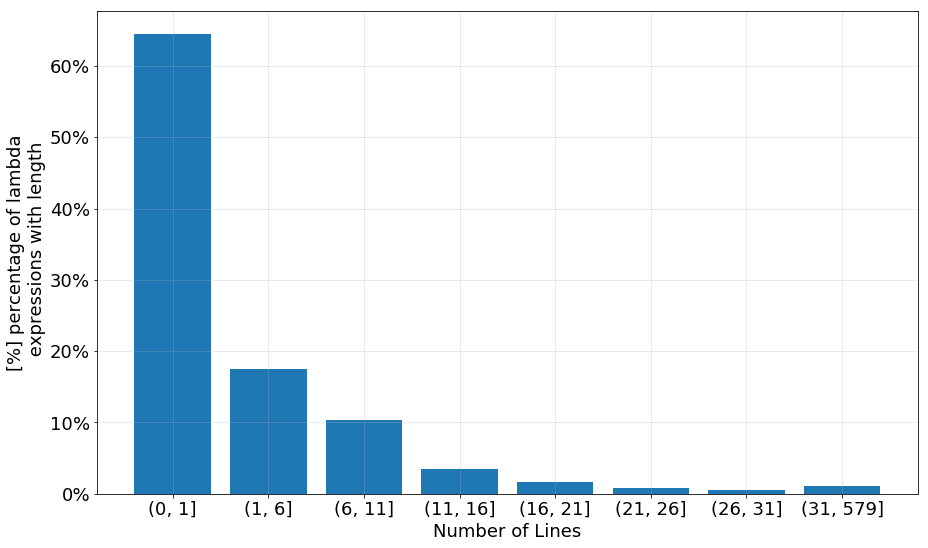

In [22]:
plt.figure(figsize=(14, 8))
plt.rcParams.update({'font.size': 18})


#plt.gca().set_yscale("log")

max_lines = 1000
indices = np.arange(len(lambdalinesToCount.index))


plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("[%] percentage of lambda\n expressions with length")
plt.xlabel("Number of Lines")

plt.grid(alpha=0.3)


plt.xticks(indices, lambdalinesToCount.index.values)


plt.tight_layout()
plt.bar(indices, lambdalinesToCount['count'])
plt.savefig("lambda_loc.png")


# How is "execute" used?

In [23]:
pd.read_sql_query("""SELECT *
        FROM LambdaInfo 
        Where not (file like "%/test/%" or file like "%/tests/%") 
        AND type IS "execute"
        """, conn).head(10)

id                              clazz  \
0  100  evaluation.InvocationFieldContext   
1  101  evaluation.InvocationFieldContext   
2  139  evaluation.InvocationFieldContext   
3  140  evaluation.InvocationFieldContext   
4  149  evaluation.InvocationFieldContext   
5  162  evaluation.InvocationFieldContext   
6  190  evaluation.InvocationFieldContext   
7  191  evaluation.InvocationFieldContext   
8  546       evaluation.InvocationContext   
9  555  evaluation.InvocationFieldContext   

                                   name     type  outside_references  \
0  InvocationFieldContext(name=execute)  execute                   1   
1  InvocationFieldContext(name=execute)  execute                   1   
2  InvocationFieldContext(name=execute)  execute                   3   
3  InvocationFieldContext(name=execute)  execute                   3   
4  InvocationFieldContext(name=execute)  execute                   2   
5  InvocationFieldContext(name=execute)  execute                   5   
6  InvocationFieldContext(name=execute)  execute                   5   
7  InvocationFieldContext(name=execute)  execute                   4   
8       InvocationContext(text=execute)  execute                   2   
9  InvocationFieldContext(name=execute)  execute                   4   

                                                file side_effecting  \
0  /home/csicar/data/Uni/BachelorArbeit/github-la...            YES   
1  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
2  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
3  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
4  /home/csicar/data/Uni/BachelorArbeit/github-la...            YES   
5  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
6  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
7  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
8  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   
9  /home/csicar/data/Uni/BachelorArbeit/github-la...         UNSURE   

   file_line                                        source_text  
0       2633  executorService.execute(()->{\n    guardedQueu...  
1       2214  executorService.execute(()->{\n    guardedQueu...  
2       2681  executorService.execute(()->makeServiceCalls(n...  
3       2608  executorService.execute(()->makeServiceCalls(a...  
4       2406  executorService.execute(()->{\n    while (inve...  
5       3493  executor.execute(()->{\n    try {\n        ful...  
6       3979  reactorMain.execute(()->{\n    try {\n        ...  
7       2338  executorService.execute(()->channel.getHandler...  
8       2181  execute((fileContext1)->fileContext1.makeQuali...  
9       5340  store.execute((fileContext)->(fileContext.util...

In [132]:
byProject = pd.read_sql_query("SELECT * FROM MethodInfo WHERE number_fp_features > 0", conn)
byProject["downloads_url"] = byProject["project_url"].map(lambda x: x[0:-7] + "downloads")


In [136]:
byProjectGrouped = byProject.groupby("downloads_url").sum()
#byProjectGrouped.set_index("project_url")
byProjectGrouped.head()

id  \
downloads_url                                                    
https://api.github.com/repos/ACRA/acra/downloads      83766372   
https://api.github.com/repos/Activiti/Activiti/...   362834079   
https://api.github.com/repos/Alluxio/alluxio/do...  1012491730   
https://api.github.com/repos/Angel-ML/angel/dow...    72439801   
https://api.github.com/repos/AntennaPod/Antenna...  1356143666   

                                                    number_fp_features  \
downloads_url                                                            
https://api.github.com/repos/ACRA/acra/downloads                    66   
https://api.github.com/repos/Activiti/Activiti/...                 207   
https://api.github.com/repos/Alluxio/alluxio/do...                 564   
https://api.github.com/repos/Angel-ML/angel/dow...                  43   
https://api.github.com/repos/AntennaPod/Antenna...                 546   

                                                    number_lines  file_line  
downloads_url                                                                
https://api.github.com/repos/ACRA/acra/downloads             785     114988  
https://api.github.com/repos/Activiti/Activiti/...          1491     725280  
https://api.github.com/repos/Alluxio/alluxio/do...          6589    4849269  
https://api.github.com/repos/Angel-ML/angel/dow...           541     243651  
https://api.github.com/repos/AntennaPod/Antenna...          7480    4581042

In [146]:
from pandas.io.json import json_normalize
repo_info = json_normalize(pd.read_json("../github-lambda-java/repos.json")["info"])
repo_info["downloads_url"] = repo_info["map.downloads_url"]
repo_info["updated_at"] = repo_info["map.updated_at"]
del repo_info["map.archive_url"]
del repo_info["map.archived"]
del repo_info["map.assignees_url"]
del repo_info["map.blobs_url"]
del repo_info["map.branches_url"]
del repo_info["map.clone_url"]
del repo_info["map.collaborators_url"]
del repo_info["map.comments_url"]
del repo_info["map.commits_url"]
repo_info.set_index("downloads_url").head()

map.compare_url  \
downloads_url                                                                                           
https://api.github.com/repos/iluwatar/java-desi...  https://api.github.com/repos/iluwatar/java-des...   
https://api.github.com/repos/elastic/elasticsea...  https://api.github.com/repos/elastic/elasticse...   
https://api.github.com/repos/ReactiveX/RxJava/d...  https://api.github.com/repos/ReactiveX/RxJava/...   
https://api.github.com/repos/spring-projects/sp...  https://api.github.com/repos/spring-projects/s...   
https://api.github.com/repos/kdn251/interviews/...  https://api.github.com/repos/kdn251/interviews...   

                                                                                     map.contents_url  \
downloads_url                                                                                           
https://api.github.com/repos/iluwatar/java-desi...  https://api.github.com/repos/iluwatar/java-des...   
https://api.github.com/repos/elastic/elasticsea...  https://api.github.com/repos/elastic/elasticse...   
https://api.github.com/repos/ReactiveX/RxJava/d...  https://api.github.com/repos/ReactiveX/RxJava/...   
https://api.github.com/repos/spring-projects/sp...  https://api.github.com/repos/spring-projects/s...   
https://api.github.com/repos/kdn251/interviews/...  https://api.github.com/repos/kdn251/interviews...   

                                                                                 map.contributors_url  \
downloads_url                                                                                           
https://api.github.com/repos/iluwatar/java-desi...  https://api.github.com/repos/iluwatar/java-des...   
https://api.github.com/repos/elastic/elasticsea...  https://api.github.com/repos/elastic/elasticse...   
https://api.github.com/repos/ReactiveX/RxJava/d...  https://api.github.com/repos/ReactiveX/RxJava/...   
https://api.github.com/repos/spring-projects/sp...  https://api.github.com/repos/spring-projects/s...   
https://api.github.com/repos/kdn251/interviews/...  https://api.github.com/repos/kdn251/interviews...   

                                                          map.created_at  \
downloads_url                                                              
https://api.github.com/repos/iluwatar/java-desi...  2014-08-09T16:45:18Z   
https://api.github.com/repos/elastic/elasticsea...  2010-02-08T13:20:56Z   
https://api.github.com/repos/ReactiveX/RxJava/d...  2013-01-08T20:11:48Z   
https://api.github.com/repos/spring-projects/sp...  2012-10-19T15:02:57Z   
https://api.github.com/repos/kdn251/interviews/...  2017-02-14T18:19:25Z   

                                                   map.default_branch  \
downloads_url                                                           
https://api.github.com/repos/iluwatar/java-desi...             master   
https://api.github.com/repos/elastic/elasticsea...             master   
https://api.github.com/repos/ReactiveX/RxJava/d...                2.x   
https://api.github.com/repos/spring-projects/sp...             master   
https://api.github.com/repos/kdn251/interviews/...             master   

                                                                                  map.deployments_url  \
downloads_url                                                                                           
https://api.github.com/repos/iluwatar/java-desi...  https://api.github.com/repos/iluwatar/java-des...   
https://api.github.com/repos/elastic/elasticsea...  https://api.github.com/repos/elastic/elasticse...   
https://api.github.com/repos/ReactiveX/RxJava/d...  https://api.github.com/repos/ReactiveX/RxJava/...   
https://api.github.com/repos/spring-projects/sp...  https://api.github.com/repos/spring-projects/s...   
https://api.github.com/repos/kdn251/interviews/...  https://api.github.com/repos/kdn251/interviews...   

                                                                                      map.descrip

In [147]:
repo_info.join(byProjectGrouped)

map.compare_url  \
0    https://api.github.com/repos/iluwatar/java-des...   
1    https://api.github.com/repos/elastic/elasticse...   
2    https://api.github.com/repos/ReactiveX/RxJava/...   
3    https://api.github.com/repos/spring-projects/s...   
4    https://api.github.com/repos/kdn251/interviews...   
5    https://api.github.com/repos/square/retrofit/c...   
6    https://api.github.com/repos/square/okhttp/com...   
7    https://api.github.com/repos/google/guava/comp...   
8    https://api.github.com/repos/spring-projects/s...   
9    https://api.github.com/repos/PhilJay/MPAndroid...   
10   https://api.github.com/repos/bumptech/glide/co...   
11   https://api.github.com/repos/airbnb/lottie-and...   
12   https://api.github.com/repos/apache/incubator-...   
13   https://api.github.com/repos/JakeWharton/butte...   
14   https://api.github.com/repos/Blankj/AndroidUti...   
15   https://api.github.com/repos/square/leakcanary...   
16   https://api.github.com/repos/zxing/zxing/compa...   
17   https://api.github.com/repos/proxyee-down-org/...   
18   https://api.github.com/repos/greenrobot/EventB...   
19   https://api.github.com/repos/Snailclimb/JavaGu...   
20   https://api.github.com/repos/crossoverJie/JCSp...   
21   https://api.github.com/repos/ReactiveX/RxAndro...   
22   https://api.github.com/repos/netty/netty/compa...   
23   https://api.github.com/repos/skylot/jadx/compa...   
24   https://api.github.com/repos/nostra13/Android-...   
25   https://api.github.com/repos/square/picasso/co...   
26   https://api.github.com/repos/Netflix/Hystrix/c...   
27   https://api.github.com/repos/alibaba/fastjson/...   
28   https://api.github.com/repos/CymChad/BaseRecyc...   
29   https://api.github.com/repos/scwang90/SmartRef...   
..                                                 ...   
970  https://api.github.com/repos/gongwen/MarqueeVi...   
971  https://api.github.com/repos/novoda/android-de...   
972  https://api.github.com/repos/niorgai/StatusBar...   
973  https://api.github.com/repos/java8/Java8InActi...   
974  https://api.github.com/repos/testcontainers/te...   
975  https://api.github.com/repos/gotev/android-upl...   
976  https://api.github.com/repos/flavienlaurent/da...   
977  https://api.github.com/repos/fanrunqi/Material...   
978  https://api.github.com/repos/RomainPiel/Shimme...   
979  https://api.github.com/repos/alibaba/TProfiler...   
980  https://api.github.com/repos/ethereum/ethereum...   
981  https://api.github.com/repos/linkedin/rest.li/...   
982  https://api.github.com/repos/tvbarthel/BlurDia...   
983  https://api.github.com/repos/Karumi/Rosie/comp...   
984  https://api.github.com/repos/Bukkit/Bukkit/com...   
985  https://api.github.com/repos/XunMengWinter/Cir...   
986  https://api.github.com/repos/seiginonakama/Blo...   
987  https://api.github.com/repos/arcadefire/nice-s...   
988  https://api.github.com/repos/hitherejoe/Androi...   
989  https://api.github.com/repos/gouthampradhan/le...   
990  https://api.github.com/repos/floragunncom/sear...   
991  https://api.github.com/repos/jeasonlzy/NineGri...   
992  https://api.github.com/repos/M66B/XPrivacy/com...   
993  https://api.github.com/repos/szerhusenBC/jwt-s...   
994  https://api.github.com/repos/frohoff/ysoserial...   
995  https://api.github.com/repos/http-kit/http-kit...   
996  https://api.github.com/repos/yadav-rahul/Tasty...   
997  https://api.github.com/repos/igniterealtime/Sm...   
998  https://api.github.com/repos/alexvasilkov/Gest...   
999  https://api.github.com/repos/Froussios/Intro-T...   

                                      map.contents_url  \
0    https://api.github.com/repos/iluwatar/java-des...   
1    https://api.github.com/repos/elastic/elasticse...   
2    https://api.github.com/repos/ReactiveX/RxJava/...   
3    https://api.github.com/repos/spring-projects/s...   
4    https://api.github.com/repos/kdn251/interviews...   
5    https://api.github.com/repos/square/retrofit/c...   
6    https://api.github.com/repos/sq